<a href="https://colab.research.google.com/github/tbrocco/mestrado/blob/main/aula7b_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data, dataset.target

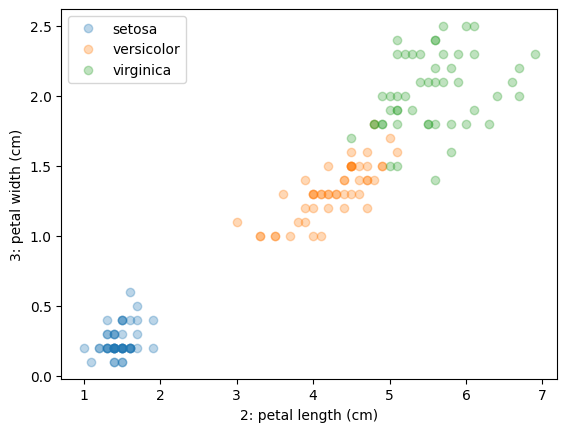

In [2]:
import matplotlib.pyplot as plt
i, j = 2,3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")
for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], "o", alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [3]:
import random
import numpy as np
def sorteiaCaracteristica(X, y):
  caracteristica = random.randint(a=0, b=X.shape[1]-1)
  valor = random.uniform(a=np.min(X[:,caracteristica]), b=np.max(X[:,caracteristica]))
  return caracteristica, valor
sorteiaCaracteristica(X, y)

(3, 1.195714735277577)

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor = sorteiaCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self

  def predict(self, X):
    y = np.empty((X.shape[0]), dtype=np.int64) #aqui a correção aplicada!
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:, self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

results = cross_validate(Arvore(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.8       , 0.73333333, 0.73333333, 0.86666667, 0.86666667]), 0.8)

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

modelo = BaggingClassifier(DecisionTreeClassifier(splitter='random'),
                           n_estimators=100)
results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.9       , 1.        ]),
 0.9466666666666667)

In [13]:
#MEU CODIGO
def sorteiaCaracteristica(X, y, seed=None):
    # if seed is not None:
    #     random.seed(seed)

    # while True:
    caracteristica = random.randint(0, X.shape[1] - 1)
    valor = random.randint(int(np.min(X[:, caracteristica])), int(np.max(X[:, caracteristica])))

    return caracteristica, valor



In [16]:
#MEU CODIGO a arvore 2
class Arvore2(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor = sorteiaCaracteristica(X, y, 42)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore2()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore2()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self

  def predict(self, X):
    y = np.empty((X.shape[0]), dtype=np.int64)
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:, self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

In [17]:
#MEU CODIGO com a ARVORE 2
from sklearn.ensemble import BaggingClassifier
modelo = BaggingClassifier(Arvore2(),
                           n_estimators=100, random_state=42)
results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.8       , 0.83333333, 0.86666667, 0.96666667, 0.93333333]),
 0.8800000000000001)

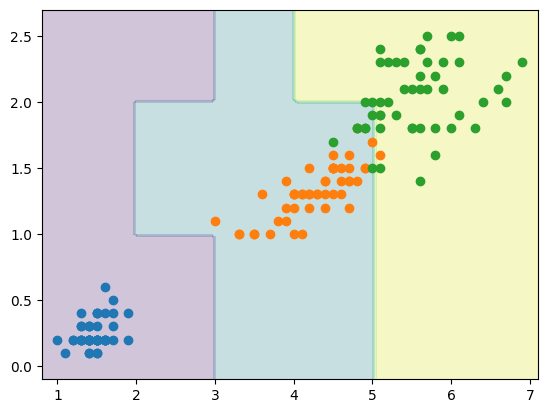

In [18]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{dataset.target_names[k]} [{k}]")
    plt.show()

plotDecisao(modelo, X[:,2:], y)

In [19]:
from sklearn.ensemble import RandomForestClassifier

results = cross_validate(RandomForestClassifier(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

results = cross_validate(ExtraTreesClassifier(), X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

modelo = VotingClassifier([
    ('knn', KNeighborsClassifier()),
    ('svm', SVC()),
    ('tree', DecisionTreeClassifier())
])

results = cross_validate(modelo, X, y)
results['test_score'], np.mean(results['test_score'])

(array([0.96666667, 0.96666667, 0.96666667, 0.93333333, 1.        ]),
 0.9666666666666666)